In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.init as init

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, roc_curve, auc

import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets
import nibabel as nib
from torchvision.transforms import functional as F
from natsort import natsorted
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
!pwd

/content


In [4]:
class VGG(nn.Module):
    def __init__(self, feature_extractor):
        super(VGG, self).__init__()
        self.feature_extractor = feature_extractor

        self.T1_feature_dimension = 1 * 128 * 6 * 6 * 6 #for input size: 192x192x192: 192/2/2/2/2/2, 5 Max Pool

        feature_dimension = self.T1_feature_dimension

        self.classifier = nn.Sequential(
            nn.Dropout(), # commented on 20201230
            nn.Linear(feature_dimension, 2048), #nn.Linear(feature_dimension, 1024), 
            nn.ReLU(True),

            nn.Dropout(),
            nn.Linear(2048, 512), #nn.Linear(1024, 128), 
            nn.Sigmoid(),
            nn.Linear(512, 2), #nn.Linear(128, 2), 
            nn.Softmax(dim = 1)
        )

         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x1):
        x1 = self.feature_extractor(x1)
        x = x1.view(x1.size(0), -1)

        x = self.classifier(x)
        return x

# 5-27-2021
class SE_block(nn.Module):
    se_ratio = 16
    def __init__(self,ch,ratio=se_ratio):
        super(SE_block, self).__init__()

        # Both should use the same complex number for initiaization which is then split into real and imaginary parts
        # Weight initialiation using the real part
        self.globalpooling = nn.AdaptiveAvgPool3d(1)
        # Weight initialization using the imag part
        self.linear1 = nn.Linear(ch,ch//ratio)
        self.relu1 = nn.ReLU()
        self.lienar2 = nn.Linear(ch//ratio,ch)
        self.sigmoid1 = nn.Sigmoid()
        self.ch = ch

    def forward(self, x):
        x_init=x
        x1=self.globalpooling(x).squeeze()
        x1=self.linear1(x1)
        x1=self.relu1(x1)
        x1=self.lienar2(x1)
        x1=self.sigmoid1(x1).reshape(x.shape[0],self.ch,1,1,1)

        return torch.mul(x_init,x1)



In [5]:
def make_layers(cfg, batch_norm=True, se_block=True):
    layers = []
    DropoutRate = 0.10

    in_channels = 1

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool3d(kernel_size=2, stride=2)] # MaxPool without Dropout # commented on 20201230
            #layers += [nn.Dropout(p=DropoutRate), nn.MaxPool3d(kernel_size=2, stride=2)] # MaxPool with Dropout rate of 0.25 # commented on 20201230
        else:
            if batch_norm:
                if se_block:
                    conv3d = nn.Conv3d(in_channels, v, kernel_size=3, padding=1)
                    se3d = SE_block(ch=v)
                    layers += [conv3d, nn.BatchNorm3d(v), se3d, nn.ReLU(inplace=True)]
                else:
                    conv3d = nn.Conv3d(in_channels, v, kernel_size=3, padding=1)
                    layers += [conv3d, nn.BatchNorm3d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv3d, nn.ReLU(inplace=True)]
            in_channels = v
    feature_extractor_T1 = nn.Sequential(*layers)

    return feature_extractor_T1

cfg = {
    'A': [16, 'M', 32, 'M', 64, 64, 'M', 128, 128, 'M', 128, 128], #'A': [32, 'M', 64, 'M', 64, 64, 'M', 128, 128, 'M', 256, 256, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [16, 16, 'M', 32, 32, 'M', 64, 64, 64, 64, 'M', 128, 128, 128, 128, 'M',
          128, 128, 128, 128, 'M'],
    'F': [32, 'M', 128, 'M', 512, 'M'],
}

In [6]:
def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E']))

def vgg16_bn():
    """VGG 16-layer model (configuration 'D') with batch normalization"""
    return VGG(make_layers(cfg['D']))

def vgg11_bn():
    """VGG 11-layer model (configuration 'A') with batch normalization"""
    return VGG(make_layers(cfg['A']))

def vgg6_bn():
    """VGG 8-layer model (configuration 'F') with batch normalization"""
    return VGG(make_layers(cfg['F']))

In [7]:
model = vgg19_bn()
model

VGG(
  (feature_extractor): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SE_block(
      (globalpooling): AdaptiveAvgPool3d(output_size=1)
      (linear1): Linear(in_features=16, out_features=1, bias=True)
      (relu1): ReLU()
      (lienar2): Linear(in_features=1, out_features=16, bias=True)
      (sigmoid1): Sigmoid()
    )
    (3): ReLU(inplace=True)
    (4): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): SE_block(
      (globalpooling): AdaptiveAvgPool3d(output_size=1)
      (linear1): Linear(in_features=16, out_features=1, bias=True)
      (relu1): ReLU()
      (lienar2): Linear(in_features=1, out_features=16, bias=True)
      (sigmoid1): Sigmoid()
    )
    (7): ReLU(inplace=True)
    (8): MaxPool3d(kernel_siz

In [8]:
def downsize_transform(data):
    target_size = (192, 192, 192)
    data = torch.from_numpy(data).unsqueeze(0).unsqueeze(0)
    downsampled = torch.nn.functional.interpolate(data, size=target_size, mode='trilinear')

    return downsampled.squeeze(0)

In [9]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transforms = None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.cn_dir = os.path.join(self.root_dir, "MNI152_affine_WB_iso1mm/CN")
        self.scz_dir = os.path.join(self.root_dir, "MNI152_affine_WB_iso1mm/schiz")
        self.samples, self.labels = self._load_samples()

    def _load_samples(self):
        samples = []

        samples = [file for file in os.listdir(self.cn_dir) if file.endswith(".nii.gz")]
        labels = [0] * len(samples)
        samples += [file for file in os.listdir(self.scz_dir) if file.endswith(".nii.gz")]
        labels += [1] * (len(samples) - len(labels))

        return samples, labels

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        label = self.labels[idx]
        if label == 0:
            file_path = os.path.join(self.cn_dir, self.samples[idx])
        else:
            file_path = os.path.join(self.scz_dir, self.samples[idx])
        one_hot_label = torch.zeros(2)
        one_hot_label[label] = 1
        label = one_hot_label

        # Load the NIfTI image
        img = nib.load(file_path)

        # Get the image data array
        img_data = np.float32(img.get_fdata())[0:192, :, 0:192]
        if self.transforms:
            img_tensor = self.transforms(img_data)
        else:
            img_tensor = torch.from_numpy(img_data).unsqueeze(0)
        return img_tensor, label

In [10]:
root_dir = "/content/drive/MyDrive/Colab Notebooks/SCZ classification"
folds_dir = [dir for dir in os.listdir(root_dir) if dir.startswith("fold")]
folds_dir = [os.path.join(root_dir, dir) for dir in folds_dir]
folds_dir = natsorted(folds_dir)
folds_dir

['/content/drive/MyDrive/Colab Notebooks/SCZ classification/fold1',
 '/content/drive/MyDrive/Colab Notebooks/SCZ classification/fold2',
 '/content/drive/MyDrive/Colab Notebooks/SCZ classification/fold3',
 '/content/drive/MyDrive/Colab Notebooks/SCZ classification/fold4',
 '/content/drive/MyDrive/Colab Notebooks/SCZ classification/fold5',
 '/content/drive/MyDrive/Colab Notebooks/SCZ classification/fold6',
 '/content/drive/MyDrive/Colab Notebooks/SCZ classification/fold7',
 '/content/drive/MyDrive/Colab Notebooks/SCZ classification/fold8',
 '/content/drive/MyDrive/Colab Notebooks/SCZ classification/fold9',
 '/content/drive/MyDrive/Colab Notebooks/SCZ classification/fold10']

In [11]:
dataloaders = []
for i in range(len(folds_dir)):
    fold_dir = folds_dir[i]
    dataset = CustomDataset(fold_dir, downsize_transform) #, downsize_transform)
    dataloader = DataLoader(dataset, batch_size=3, shuffle=True)
    dataloaders.append(dataloader)
    print("fold", i+1, ": ", len(dataset))

fold 1 :  196
fold 2 :  188
fold 3 :  187
fold 4 :  185
fold 5 :  187
fold 6 :  185
fold 7 :  187
fold 8 :  182
fold 9 :  188
fold 10 :  187


torch.Size([3, 1, 192, 192, 192])
<built-in method type of Tensor object at 0x79392cf7a980>
tensor([[1., 0.],
        [0., 1.],
        [1., 0.]])
torch.Size([3, 2])


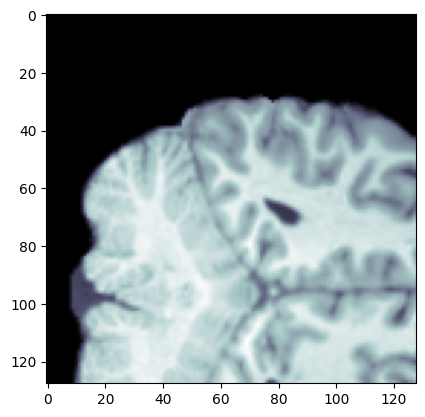

In [12]:
sample = next(iter(dataloaders[0]))
plt.imshow(sample[0][0][0][0:128, int(128/2), 0:128], cmap = 'bone')
print(sample[0].shape)
print(sample[0].type)
print(sample[1])
print(sample[1].shape)

In [13]:
def train_net(net, epochs, train_dataloader, valid_loader, optimizer, loss_function, device, check_pt_dir):
    os.makedirs(check_pt_dir, exist_ok=True)
    net.to(device)
    ret_train_loss = []
    ret_valid_loss = []
    min_vloss = math.inf

    for epoch in range(epochs):
        net.train()

        train_loss = []
        for i, (img, label) in enumerate(train_dataloader):
            img= img.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            y_pred = net(img)
            loss = loss_function(y_pred, label)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            print(f'{i + 1}/{len(train_dataloader)}| current training loss: {train_loss[-1]}', end='\r')

            # Deleting variables and emptying the cache might not always lead to significant memory savings
            # because PyTorch uses a caching memory allocator to improve performance. Consider using it
            # judiciously based on the actual memory footprint observed.
            #del img, label, y_pred, loss
            # torch.cuda.empty_cache()

        train_epoch_loss = np.mean(train_loss)
        ret_train_loss.append(train_epoch_loss)
        print(f'epoch {epoch}| training loss: {train_epoch_loss}', end='\r')

        # Validation phase
        net.eval()
        valid_loss = []
        with torch.no_grad():
            for i, (img, label) in enumerate(valid_loader):
                img = img.to(device)
                label = label.to(device)
                y_pred = net(img)
                loss = loss_function(y_pred, label)
                valid_loss.append(loss.item())
                print(f'{i + 1}/{len(valid_loader)}| current validation loss: {valid_loss[-1]}', end='\r')

                # del img, label, y_pred, loss
                # torch.cuda.empty_cache()

        epoch_vloss = np.mean(valid_loss)
        if epoch_vloss < min_vloss:
            model_filename = f'Epoch_{epoch}_VLoss_{epoch_vloss:.4f}.pth'
            model_path = os.path.join(check_pt_dir, model_filename)
            torch.save(model.state_dict(), model_path)

        print(f"epoch {epoch} | training loss: {train_epoch_loss:.4f} | validation loss: {epoch_vloss:.4f}")
        ret_valid_loss.append(epoch_vloss)

    return ret_train_loss, ret_valid_loss

In [14]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss()
# train_loss , valid_loss = train_net(model, 10, dataloaders[0], dataloaders[1], optimizer, loss_function, device)

In [15]:
check_dir = "/content/checkpoints/"

temp_dir = "/content/checkpoints/temp.pth"
overall_train_loss = []
overall_valid_loss = []
os.makedirs(check_dir, exist_ok=True)
torch.save(model.state_dict(), temp_dir)
for i in range(9):
    valid_set = dataloaders[i]
    train_set = [index for index in range(9)if index != i]
    model.load_state_dict(torch.load(temp_dir))
    for j in range(5):
        for index in train_set:
            print(f"outer epoch: {j}    fold {index}")
            train_loss, valid_loss = train_net(model, 1, dataloaders[index], valid_set, optimizer, loss_function, device, check_dir)
            overall_train_loss.append(train_loss)
            overall_valid_loss.append(valid_loss)

outer epoch:0
epoch 0 | training loss: 0.7223 | validation loss: 0.761326
epoch 0 | training loss: 0.7175 | validation loss: 0.74003
epoch 0 | training loss: 0.6987 | validation loss: 0.68607
epoch 0 | training loss: 0.7142 | validation loss: 0.6852
epoch 0 | training loss: 0.6704 | validation loss: 0.66611
epoch 0 | training loss: 0.7060 | validation loss: 0.67342
epoch 0 | training loss: 0.6578 | validation loss: 0.6858
epoch 0 | training loss: 0.6768 | validation loss: 0.666224
outer epoch:1
epoch 0 | training loss: 0.6919 | validation loss: 0.68409
epoch 0 | training loss: 0.6924 | validation loss: 0.67934
epoch 0 | training loss: 0.6825 | validation loss: 0.68511
epoch 0 | training loss: 0.7010 | validation loss: 0.67829
epoch 0 | training loss: 0.6772 | validation loss: 0.66464
epoch 0 | training loss: 0.6874 | validation loss: 0.69115
epoch 0 | training loss: 0.6726 | validation loss: 0.66319
epoch 0 | training loss: 0.6729 | validation loss: 0.662977
outer epoch:2
epoch 0 | tra

KeyboardInterrupt: 

In [ ]:
def test_net(net, test_dataloader):
    net.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for i, (img, label) in enumerate(test_dataloader):
            img = img.to(device)
            y_pred = net(img)
            labels.append(label.numpy())
            predictions.append(y_pred.cpu().numpy())
    predictions = np.concatenate(predictions)
    labels = np.concatenate(labels)
    return predictions, labels


In [ ]:
pred, labels = test_net(model, dataloaders[2])

In [ ]:
pred_labels = np.argmax(pred, axis=1)
true_labels = np.argmax(labels, axis=1)
cm = confusion_matrix(true_labels, pred_labels)
print(cm)

In [ ]:

# Set up figure
plt.figure(figsize=(8, 6))

# Use Seaborn to create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
fpr, tpr, thres = roc_curve(labels, pred)
roc_auc = roc_auc_score(labels, pred)  # Calculate the ROC AUC score

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')  # Include the AUC score in the label
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()